LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [ ]:
%%bash
FILE=/content/portfolio_tools.py
if [[ ! -f $FILE ]]; then
    wget https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
fi

In [ ]:
!pip install mosek 
!export PYTHONPATH="$PYTHONPATH:/content"

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem. 
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.

In [1]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [ ]:
# Colab additional settings
os.environ['MOSEKLM_LICENSE_FILE']="/content:/root/mosek"

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data(read_volume=True)
df_prices, df_volumes = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

The parameter `a` is the coefficient vector in the market impact cost term, the parameter `beta` is used in the exponent in the market impact formula, and `rf` is the risk free interest rate.

In [6]:
def EfficientFrontier(N, m, G, deltas, a, beta, rf):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Variable for risk-free asset (cash account)
        xf = M.variable("xf", 1, Domain.greaterThan(0.0))        
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
        
        # Auxiliary variable to model market impact 
        t = M.variable("t", N, Domain.unbounded())

        # Budget constraint with transaction cost terms
        M.constraint('budget', Expr.sum(Expr.hstack(Expr.sum(x), xf, Expr.dot(a, t))), Domain.equalsTo(1))
        
        # Power cone to model market impact 
        M.constraint('market_impact', Expr.hstack(t, Expr.constTerm(N, 1.0), x), Domain.inPPowerCone(1.0 / beta))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, 
                    Expr.sub(
                        Expr.add(Expr.dot(m, x), Expr.mul(rf, xf)), 
                        Expr.mul(delta, s)
                    )
        )
        
        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 1, Expr.mul(G.transpose(), x)), Domain.inRotatedQCone())
    
        columns = ["delta", "obj", "return", "risk", "t_resid", "x_sum", "xf", "tcost"] + df_prices.columns.tolist()
        
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level() + np.array([rf]) @ xf.level()
            portfolio_risk = np.sqrt(2 * s.level()[0]) 
            risky_return = m @ x.level()
            t_resid = t.level() - np.abs(x.level())**beta
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, 
                             sum(t_resid), sum(x.level()), sum(xf.level()), t.level() @ a] + list(x.level()), index=columns)
     
            df_result = df_result.append(row, ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [7]:
# Number of securities
N = df_prices.shape[1]

# Get optimization parameters
m, S = compute_inputs(df_prices)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [8]:
G = np.linalg.cholesky(S)  

We also compute the average daily volume and daily volatility (std. dev.)

In [9]:
df_lin_returns = df_prices.pct_change()
volatility = df_lin_returns.std()
volume = (df_volumes * df_prices).mean()

Finally we specify the parameters of market impact, risk free rate, and portfolio size.

In [10]:
# Market impact coefficient
beta = 3 / 2
c = 1
rf = 0.01
portfolio_value = 10**10

# Compute portfolio relative volume , because the variable x is also portfolio relative.
rel_volume = volume / portfolio_value

# a1 means no impact, a2 means impact
a1 = np.zeros(N)
a2 = (c * volatility / rel_volume**(beta - 1)).to_numpy()

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute and plot the efficient frontier this way both with and without market impact cost. 

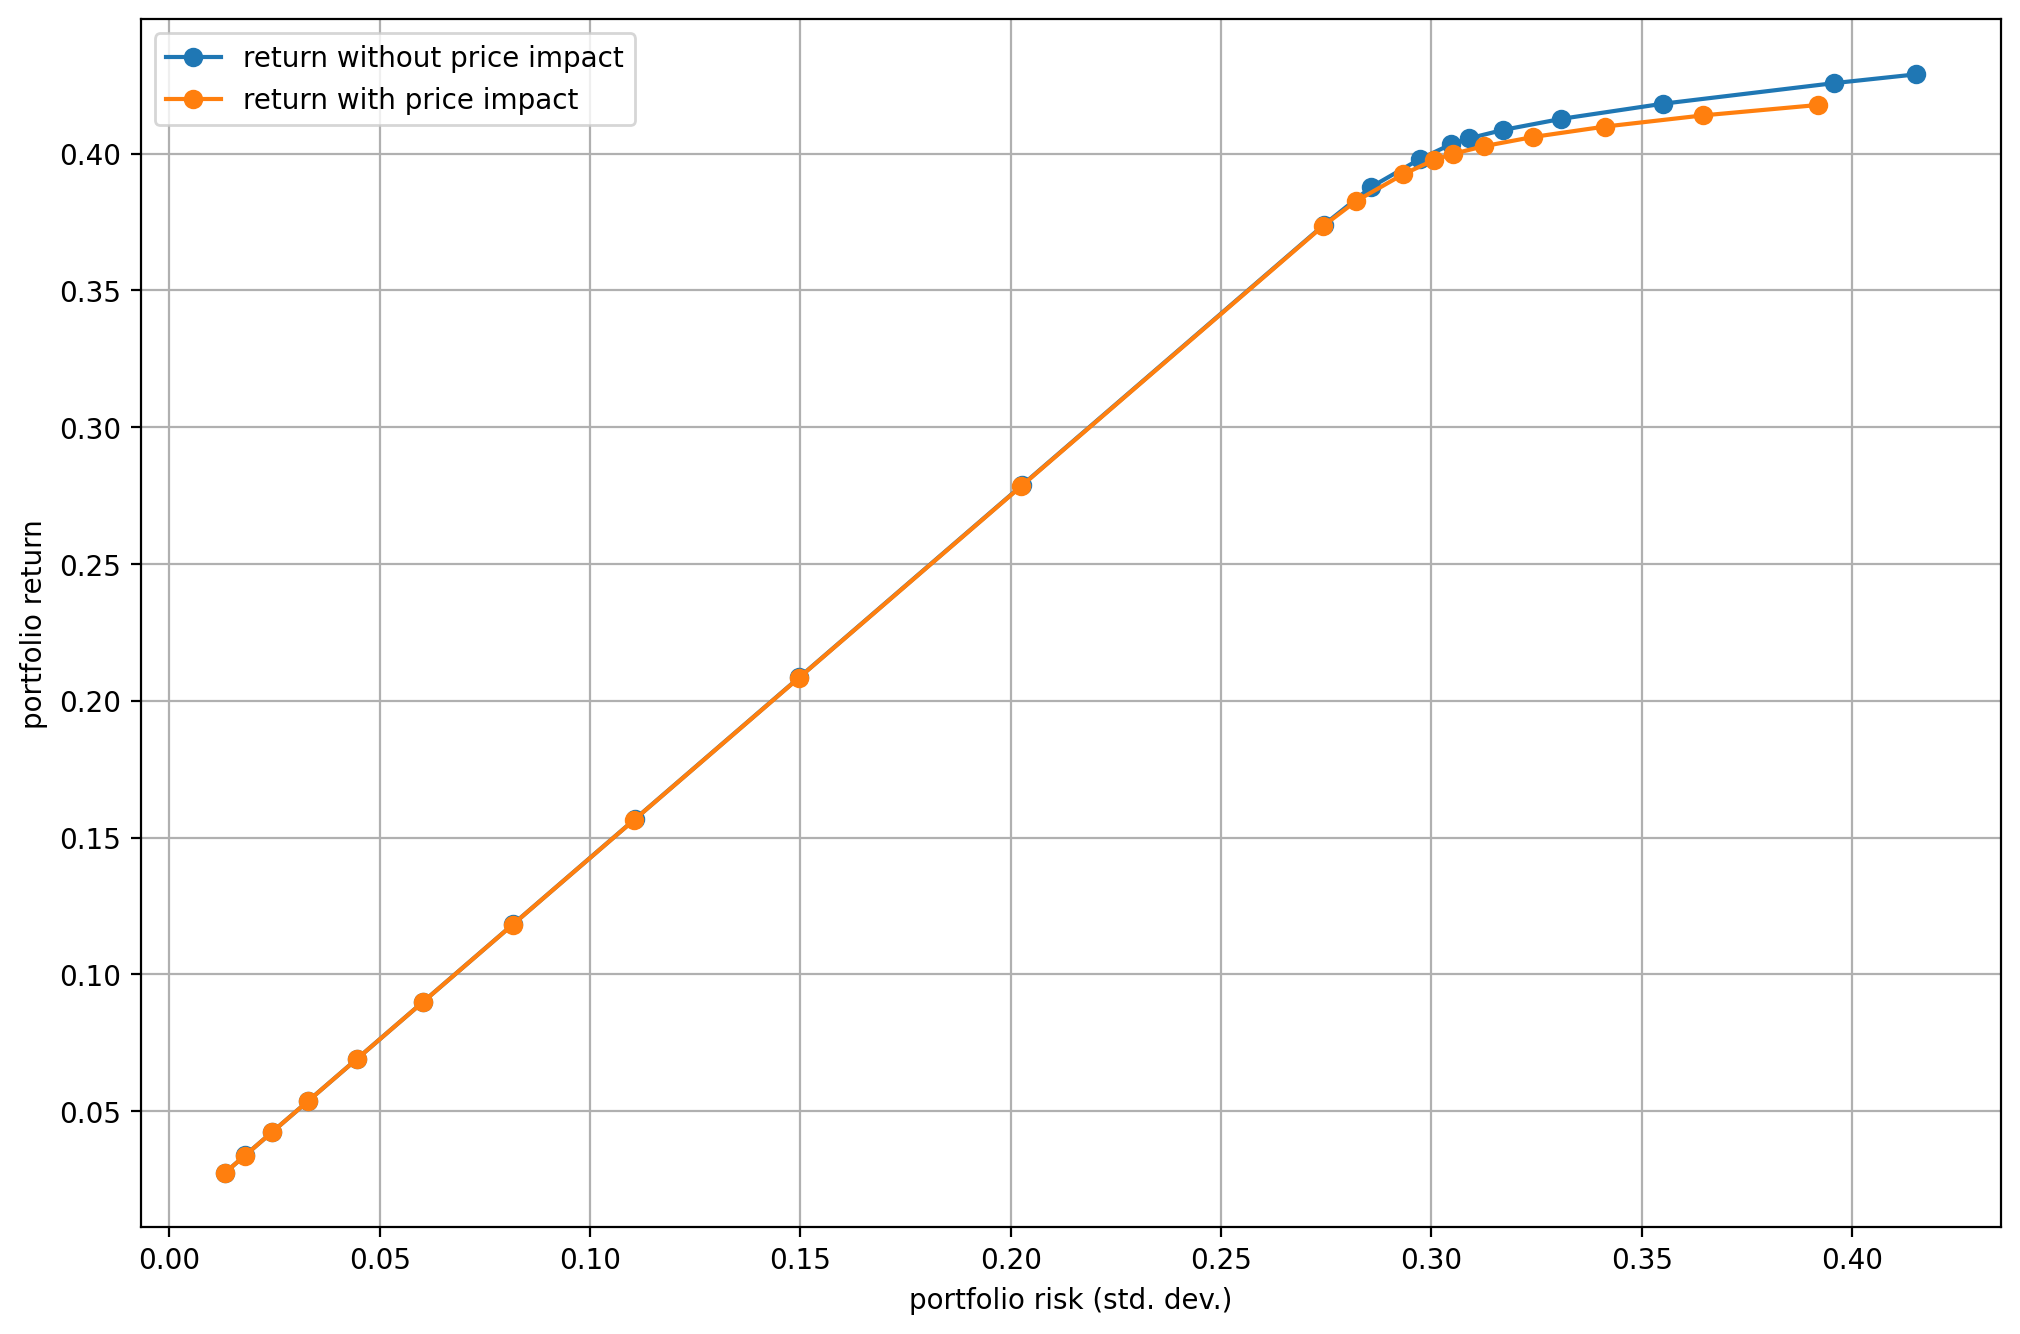

In [11]:
deltas = np.logspace(start=-0.5, stop=2, num=20)[::-1]

ax = plt.gca()
for a in [a1, a2]:
    df_result = EfficientFrontier(N, m, G, deltas, a, beta, rf)
    df_result.plot(ax=ax, x="risk", y="return", style="-o", 
                   xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
ax.legend(["return without price impact", "return with price impact"])